In [17]:
dataset <- "SIRToscana"
state <- "Toscana"


In [18]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(DBI, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source("src/database/startup.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/database/query/pairing.R")
source("src/database/query/analysis.R")
source("src/pairing/displaying.R")
source("src/database/plot.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


In [3]:
query <- glue::glue_sql(
    "
        WITH state_station AS (
            SELECT DISTINCT on (s.id)
                s.dataset,
                s.id,
                s.geom,
                s.geog
            FROM station_geo s
            JOIN boundary b
            ON ST_Within(s.geom, b.geom)
            WHERE b.name = {state} OR s.dataset = {dataset}
        )
        SELECT
            sx.dataset AS dataset_x,
            sx.id AS id_x,
            sy.dataset AS dataset_y,
            sy.id AS id_y,
            ST_Distance(sx.geog, sy.geog) AS distance
        FROM state_station sx
        JOIN state_station sy
        ON ST_DWithin(sx.geog, sy.geog, 6000)
        WHERE sx.id != sy.id
    ",
    .con = conns$stations
)
close_stations <- dbGetQuery(conns$stations, query)
dbWriteTable(
    conns$data,
    "close_stations_tmp",
    close_stations,
    overwrite = TRUE
)


In [4]:
dbExecute(conns$data, "SET memory_limit = '12.5GB'")


[1] 0

In [5]:
metadata <- tbl(conns$data, "stations_tmp")
dbExecute(conns$data, "DROP TABLE IF EXISTS data_tmp")
data <- valid_data(conns$data) |>
    semi_join(metadata, join_by(station_id == id)) |>
    compute(temporary = FALSE, name = "data_tmp")
matches <- data |>
    valid_series() |>
    collect() |>
    series_matches(tbl(conns$data, "close_stations_tmp") |> collect(), asymmetric = TRUE, cmp = \(x, y) x > y) |>
    select(id_x, id_y, variable, distance)


[1] 0

In [6]:
analysis <- series_matches_analysis(matches, data, metadata)


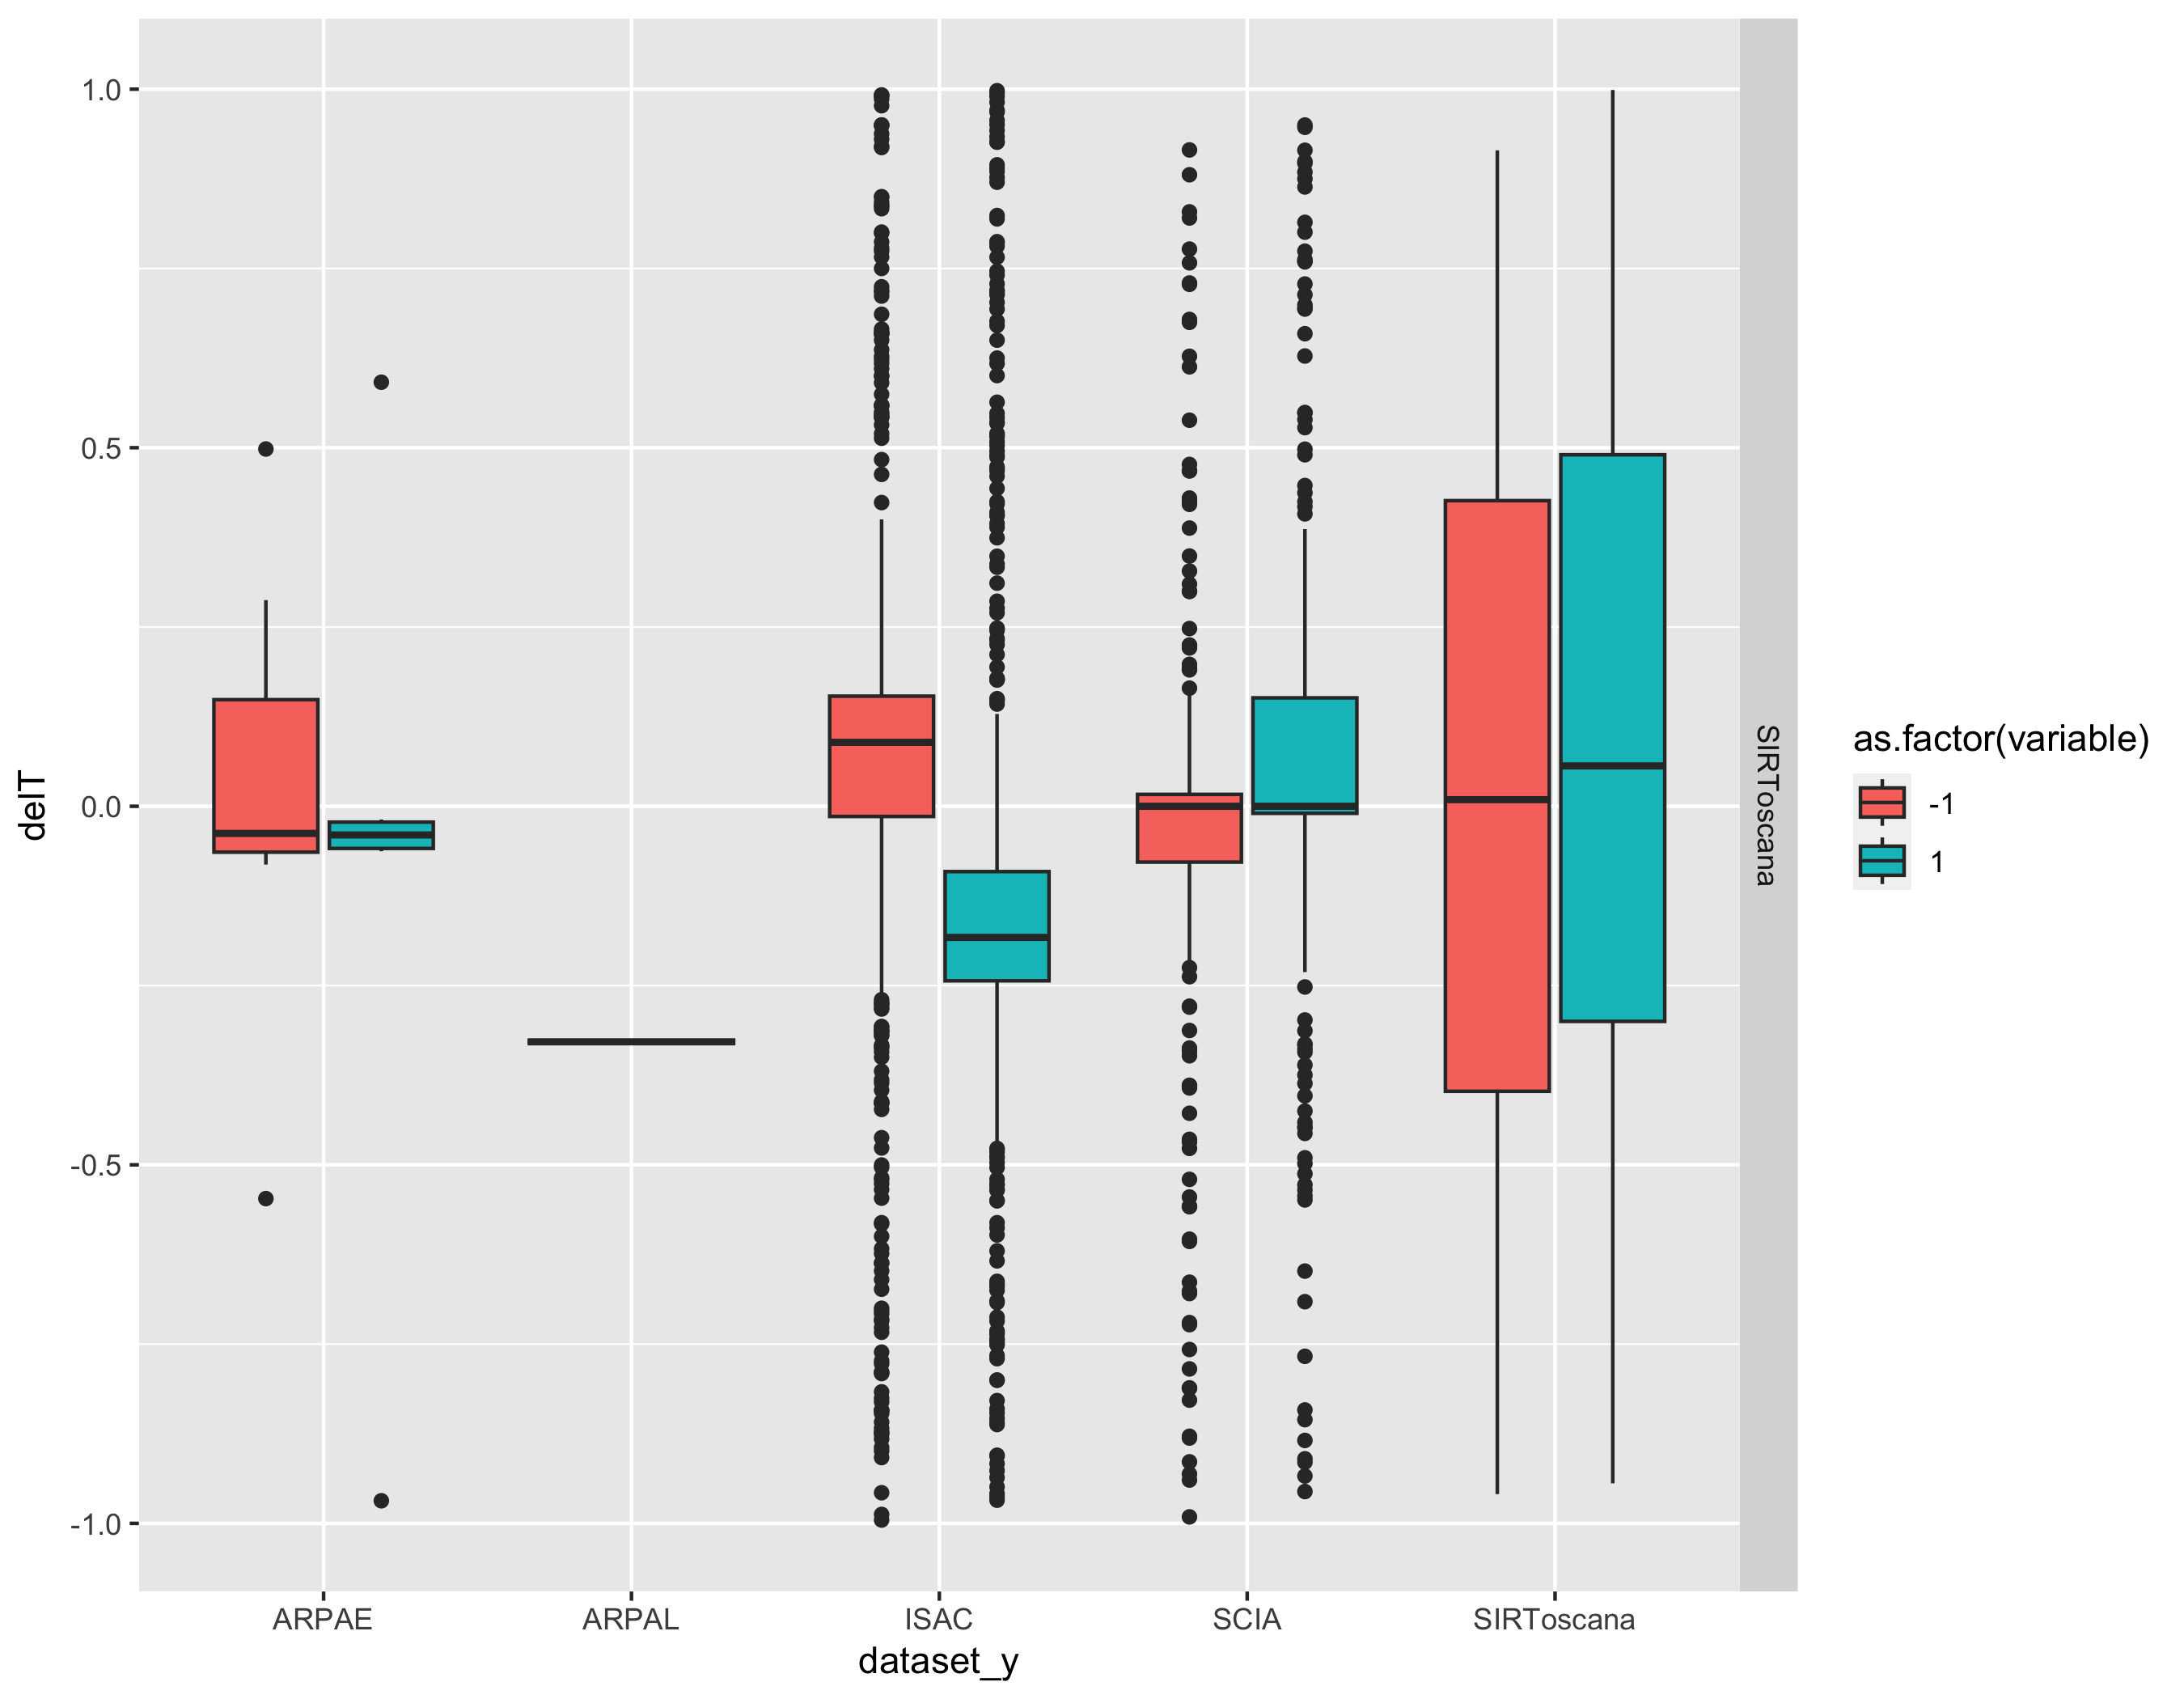

In [8]:
library(ggplot2)
ggplot(data = analysis |> filter(dataset_x == !!dataset, abs(delT) < 1)) + geom_boxplot(aes(x = dataset_y, y = delT, fill = as.factor(variable))) + facet_grid(dataset_x ~ .)

SCIA e SIRToscana registrano le stesse variabili, mentre quelle di ISAC sono sistematicamente meno estreme: probabilmente in Toscana ISAC prende gli estremi delle medie orarie

In [9]:
write_xslx_analysis(analysis, file.path("notebooks", "integrazioni_regionali", "toscana", "analysis.xlsx"))


ATTENZIONE: diverse stazioni di ISAC sembrano etichettate in maniera scorretta. Droppare ciò che resta.

Warning message:
"ORDER BY is ignored in subqueries without LIMIT
i Do you need to move arrange() later in the pipeline or use window_order() instead?"
Warning message:
"ORDER BY is ignored in subqueries without LIMIT
i Do you need to move arrange() later in the pipeline or use window_order() instead?"


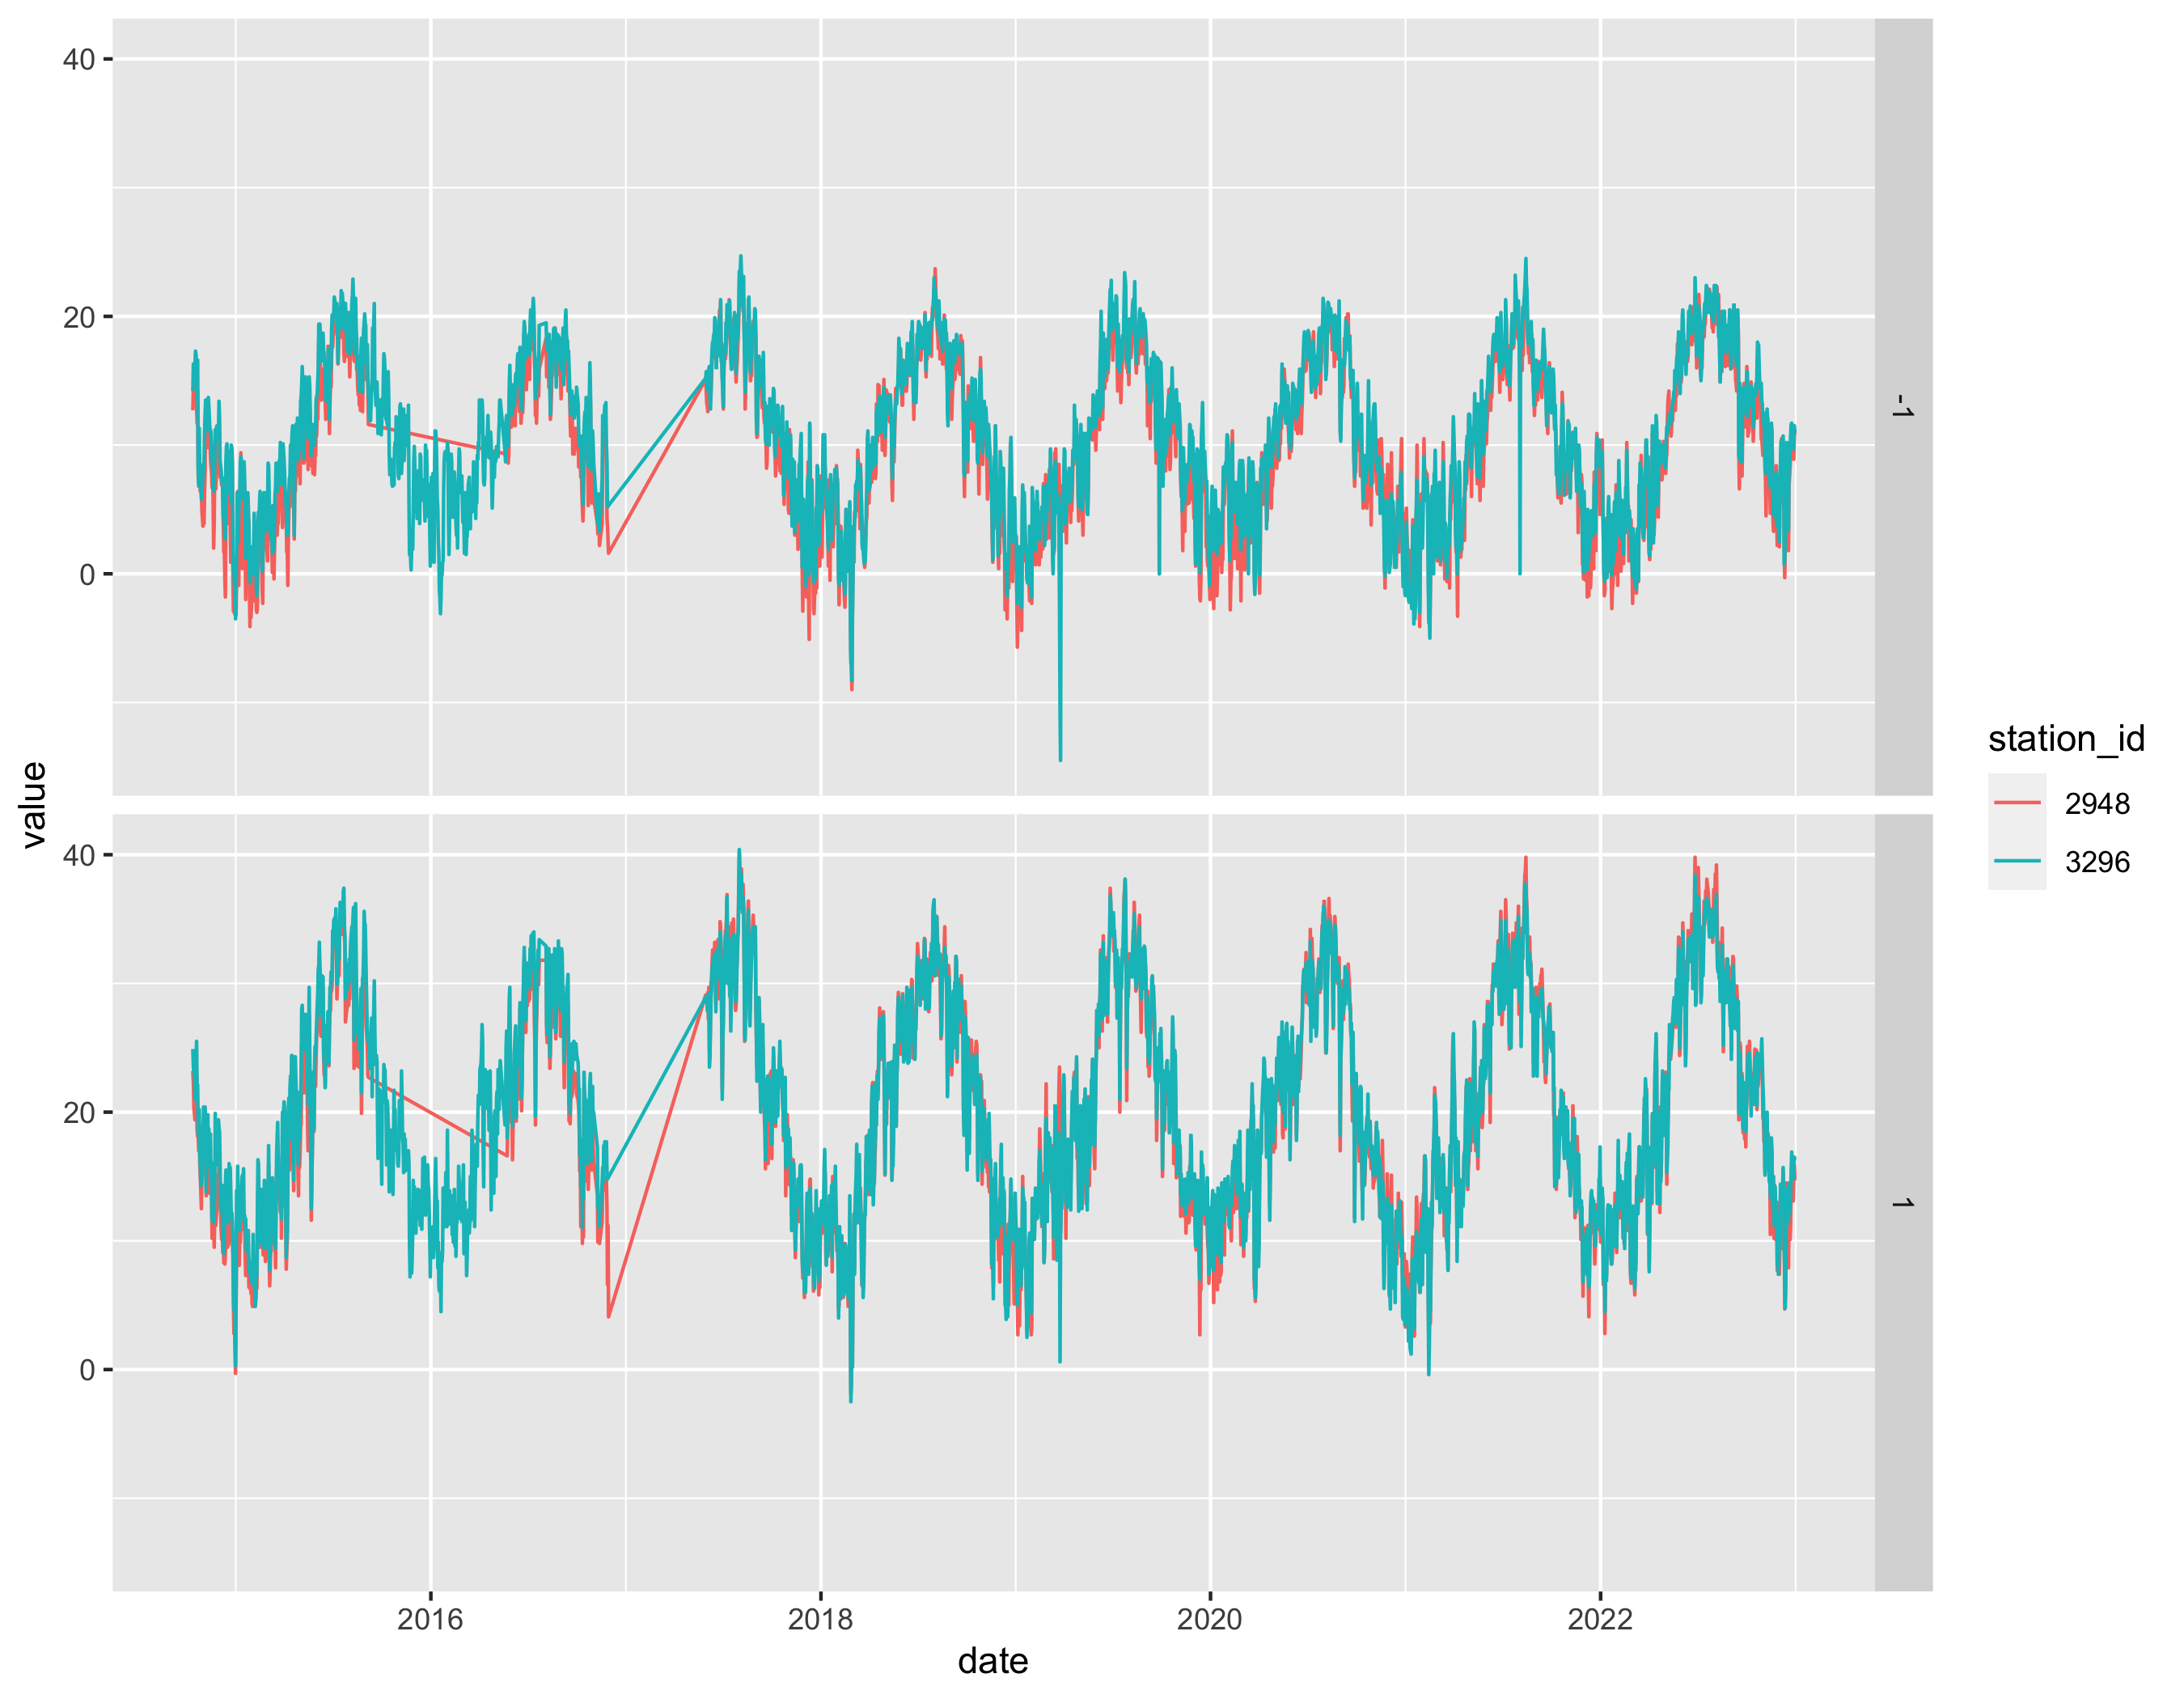

In [20]:
plot_stations(tibble(station_id = c(3296L, 2948L)), conns$data)

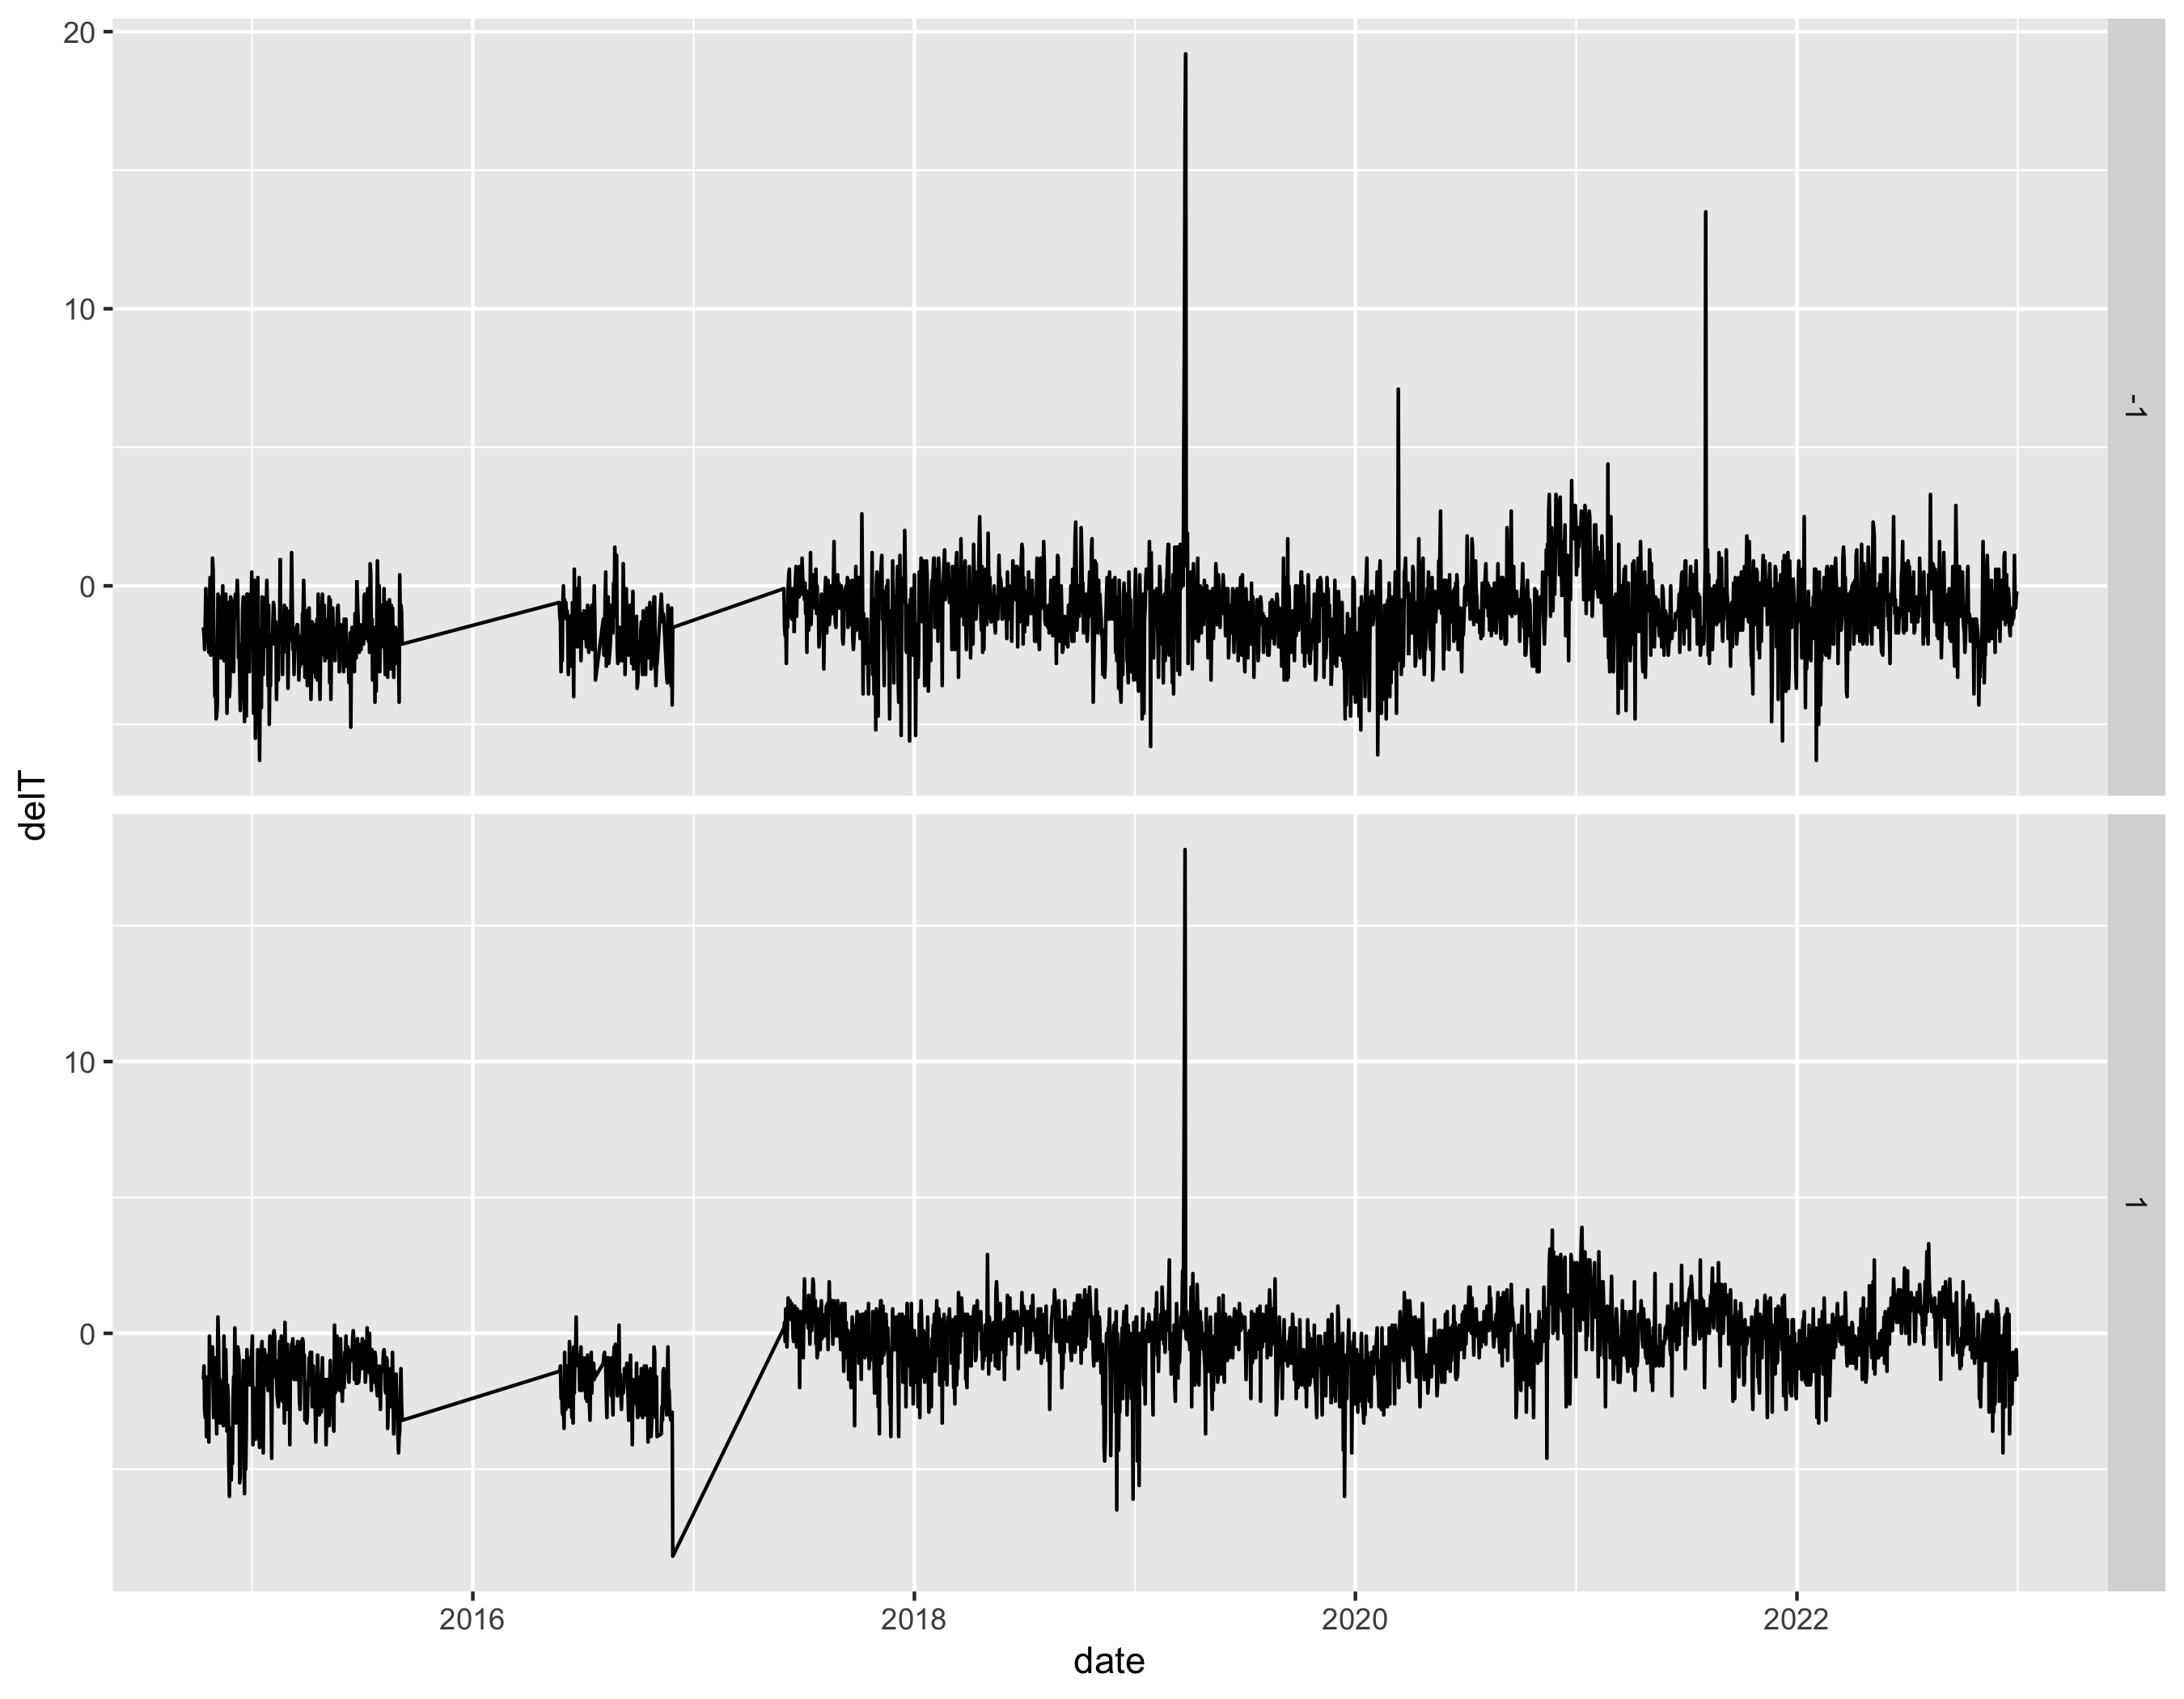

In [21]:
analysis |> filter(id_x == 3296L, id_y == 2948L) |> plot_diffs(conns$data)

## Merging [TBD]
Gap-filling con altri dataset

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [ ]:
qc_state <- open_checkpoint(dataset_id, "qc1")
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries)
analysis_results <- perform_analysis(
    qc_state,
    qc_scia,
    dist_km = , # 10,
    first_date,
    last_date,
    str_to_lower(state),
)

rm(qc_state)
rm(qc_scia)
gc()


In [ ]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L & n != 4L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


In [ ]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 1, match_selectors = NULL)
checkpoint_database(combination_results$database, dataset_id, "scia_merged")
save_match_list(combination_results$match_list, dataset_id, "scia_merged")


In [ ]:
stations <- open_metadata(c(dataset, "SCIA", "ISAC"), "raw", TRUE) |> filter_inside(state_boundaries)
state_data <- query_from_checkpoint(c(dataset, "SCIA", "ISAC"), "raw") |>
    semi_join.ddb(stations, join_by(dataset, station_id == id))

c(p, ymonthly_avail) %<-% ymonthly_availabilities(state_data)
p


In [ ]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, stations, state_boundaries)
p


In [ ]:
rm(stations, state_data, ymonthly_avail, climats, p)
gc()


### Merge interno

In [ ]:
scia_merged <- open_checkpoint(dataset_id, "scia_merged")
analysis_results <- perform_analysis_symmetric(
    scia_merged,
    dist_km = 6,
    first_date,
    last_date,
    file.path("vda", "internal.xlsx"),
    default_symmetric_filter,
    priority_table = NULL,
)

rm(scia_merged)
gc()


In [ ]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_internal, "unusable" = tag_unusable_internal))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L & n != 4L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


In [ ]:
combination_results <- build_combined_database(analysis_results, use_corrections = TRUE, checks = TRUE, test_bounds = 1.5, match_selectors = NULL)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")
rm(combination_results)
gc()


In [ ]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


In [ ]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [ ]:
print("Available series per variable:")
climats |>
    as_tibble() |>
    group_by(variable, station_id) |>
    summarise(usable = all(clim_available), .groups = "drop_last") |>
    filter(usable) |>
    tally()


In [ ]:
rm(ymonthly_avail)
rm(climats)
rm(combined_database)
gc()


In [ ]:
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(dataset_id, "merged")$data |>
    distinct(station_id, variable) |>
    compute() |>
    nrow()
